In [ ]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv("eclsk.csv")

print(df.columns.tolist())

['CHILDID', 'S1_ID', 'GENDER', 'WKWHITE', 'WKSESL', 'RIRT', 'MIRT', 'S2KPUPRI', 'P1EXPECT', 'P1FIRKDG', 'P1AGEENT', 'apprchT1', 'P1HSEVER', 'chg14', 'P1FSTAMP', 'S2KMINOR', 'ONEPARENT', 'STEPPARENT', 'P1NUMSIB', 'P1HMAFB', 'WKCAREPK', 'P1EARLY', 'wt_ounces', 'C1FMOTOR', 'C1GMOTOR', 'P1HSCALE', 'P1SADLON', 'P1IMPULS', 'P1ATTENI', 'P1SOLVE', 'P1PRONOU', 'P1DISABL', 'F5SPECS', 'C5R4RSCL', 'C6R4RSCL', 'C5R4MSCL', 'C6R4MSCL', 'avg_RIRT', 'avg_MIRT', 'avg_SES', 'avg_apprchT1']


In [ ]:
import pandas as pd

df = pd.read_csv("eclsk.csv")

y_var = 'avg_MIRT' 
x_var = 'P1EARLY'  
a_vars = [
    'WKSESL',
    'ONEPARENT',
    'P1ATTENI',
    'apprchT1',
    'P1EXPECT',
    'WKCAREPK',
    'P1HSCALE',
    'P1AGEENT',
    'P1SADLON',
    'P1FSTAMP'
]

model_df = df[[y_var, x_var] + a_vars].copy()
model_df = model_df.dropna()

print(f"处理后样本量：{model_df.shape[0]} 行，变量数：{model_df.shape[1]}")
print(model_df.head())

处理后样本量：7362 行，变量数：12
   avg_MIRT  P1EARLY  WKSESL  ONEPARENT  P1ATTENI  apprchT1  P1EXPECT  WKCAREPK  P1HSCALE  P1AGEENT  P1SADLON  P1FSTAMP
0  40.61000       70    1.56          0         2      3.33         5         1         2        74      1.50         0
1  40.61000        0    1.41          0         2      2.83         6         1         3        67      1.67         0
2  35.18375        0   -2.93          0         1      2.83         6         1         1        71      1.75         0
3  35.18375        0    0.54          0         2      2.83         4         1         1        63      2.00         0
4  35.18375        0    0.15          0         2      1.50         6         1         1        68      2.25         0


In [ ]:
import pandas as pd

df = pd.read_csv("eclsk.csv")

id_var = 'CHILDID'    
y_var = 'avg_MIRT'  
x_var = 'P1EARLY'      
a_vars = [
    'WKSESL',
    'ONEPARENT',
    'P1ATTENI',
    'apprchT1',
    'P1EXPECT',
    'WKCAREPK',
    'P1HSCALE',
    'P1AGEENT',
    'P1SADLON',
    'P1FSTAMP'
]

cols = [id_var, y_var, x_var] + a_vars
model_df = df[cols].copy()

model_df = model_df.dropna()

model_df.to_csv("final.csv", index=False)

print(f"已保存文件：final.csv，样本量：{model_df.shape[0]}，变量数：{model_df.shape[1]}")

已保存文件：final.csv，样本量：7362，变量数：13


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("final.csv")

y = df['avg_MIRT'].values
t = df['P1EARLY'].values
X = df.drop(columns=['CHILDID', 'avg_MIRT', 'P1EARLY']).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ps_model = LogisticRegression(solver='liblinear')
ps_model.fit(X_scaled, t)
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]

treated_idx = np.where(t == 1)[0]
control_idx = np.where(t == 0)[0]

nn = NearestNeighbors(n_neighbors=1)
nn.fit(propensity_scores[control_idx].reshape(-1, 1))
distances, matched_control_idx = nn.kneighbors(propensity_scores[treated_idx].reshape(-1, 1))

treated_outcomes = y[treated_idx]
matched_control_outcomes = y[control_idx][matched_control_idx.flatten()]
ate = np.mean(treated_outcomes - matched_control_outcomes)


print(f"传统 PSM 匹配后估计的 ATE：{ate:.4f}")

传统 PSM 匹配后估计的 ATE：0.3645


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from econml.bart import BART
import matplotlib.pyplot as plt

df = pd.read_csv("final.csv")
y = df["avg_MIRT"].values
T = df["P1EARLY"].values
X = df.drop(columns=["CHILDID", "avg_MIRT", "P1EARLY"]).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = BART()
model.fit(Y=y, T=T, X=X_scaled)

ate = model.ate(X=X_scaled)
print(f"BART 估计的 ATE：{ate:.4f}")

ite = model.effect(X_scaled)

plt.figure(figsize=(8, 5))
plt.hist(ite, bins=30, edgecolor='black')
plt.title("Individual Treatment Effects (ITE) Distribution - BART")
plt.xlabel("ITE value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'econml.bart'

Starting burn
Starting burn
Starting burn
Starting burn


  0%|          | 0/200 [00:00<?, ?it/s]

Starting sampling
Starting sampling
Starting sampling
Starting sampling


100%|██████████| 200/200 [00:03<00:00, 57.48it/s]


Starting burn
Starting burn


  1%|          | 2/200 [00:00<00:17, 11.22it/s]

Starting burn
Starting burn


 94%|█████████▍| 189/200 [00:06<00:00, 29.62it/s]

Starting sampling


  8%|▊         | 17/200 [00:00<00:06, 30.05it/s]

Starting sampling
Starting sampling


 12%|█▏        | 23/200 [00:00<00:05, 29.57it/s]

Starting sampling


100%|██████████| 200/200 [00:07<00:00, 27.53it/s]


BART 估计的 ATE：5.2098


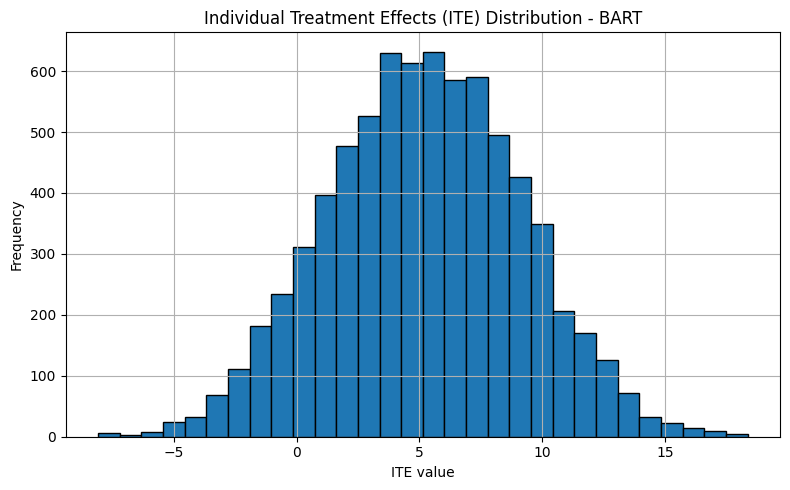

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from bartpy.sklearnmodel import SklearnModel
import matplotlib.pyplot as plt

df = pd.read_csv("final.csv")
y = df["avg_MIRT"].values  
T = df["P1EARLY"].values  
X = df.drop(columns=["CHILDID", "avg_MIRT", "P1EARLY"]).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_treated = SklearnModel()
model_control = SklearnModel()

model_treated.fit(X_scaled[T == 1], y[T == 1])
model_control.fit(X_scaled[T == 0], y[T == 0])

mu1 = model_treated.predict(X_scaled)
mu0 = model_control.predict(X_scaled)
ite = mu1 - mu0

ate = np.mean(ite)
print(f"BART 估计的 ATE：{ate:.4f}")

plt.figure(figsize=(8, 5))
plt.hist(ite, bins=30, edgecolor='black')
plt.title("Individual Treatment Effects (ITE) Distribution - BART")
plt.xlabel("ITE value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("final.csv")

y = df["avg_MIRT"].values
T = df["P1EARLY"].values
X = df.drop(columns=["CHILDID", "avg_MIRT", "P1EARLY"]).values
child_ids = df["CHILDID"].values
ses = df["WKSESL"].values

from sklearn.preprocessing import StandardScaler
from bartpy.sklearnmodel import SklearnModel

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_treated = SklearnModel()
model_control = SklearnModel()

model_treated.fit(X_scaled[T == 1], y[T == 1])
model_control.fit(X_scaled[T == 0], y[T == 0])

mu1 = model_treated.predict(X_scaled)
mu0 = model_control.predict(X_scaled)
ite = mu1 - mu0
ate = np.mean(ite)
print(f"总 ATE：{ate:.4f}")

df["ITE"] = ite
df["SES"] = ses

df["SES_group"] = pd.qcut(df["SES"], q=3, labels=["Low", "Medium", "High"])

grouped = df.groupby("SES_group")["ITE"].mean()
print("\n按 SES 分组的 CATE：")
print(grouped)

ite_df = df[["CHILDID", "avg_MIRT", "P1EARLY", "ITE"]]
ite_df.to_csv("ite_results.csv", index=False)
print("\nITE 结果已保存为 ite_results.csv")

KeyError: 'P1EARLY'

In [9]:
print("T=0 样本数：", np.sum(T == 0))
print("T=1 样本数：", np.sum(T == 1))

T=0 样本数： 6155
T=1 样本数： 5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from econml.grf import CausalForest
import matplotlib.pyplot as plt

df = pd.read_csv("final.csv")
y = df["avg_MIRT"].values
T = df["P1EARLY"].values
X = df.drop(columns=["CHILDID", "avg_MIRT", "P1EARLY"])
child_ids = df["CHILDID"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"T=0 样本数：{sum(T==0)}")
print(f"T=1 样本数：{sum(T==1)}")

if sum(T==1) < 10:
    raise ValueError("处理组样本过少（<10），无法进行可靠估计")

model = CausalForest(
    n_estimators=1000,
    min_samples_leaf=10,
    random_state=42,  
    imbalance_penalty=0.5 
)
model.fit(X=X_scaled, y=y, T=T)

ate = model.ate()
print(f"\nCausal Forest 估计的 ATE：{ate:.4f}")

ite = model.predict(X_scaled) 

df["ITE_CF"] = ite

df["SES"] = df["WKSESL"]
df["SES_group"] = pd.qcut(df["SES"], q=3, labels=["Low", "Medium", "High"])
cate_grouped = df.groupby("SES_group")["ITE_CF"].mean()
print("\n按 SES 分组的 CATE（Causal Forest）：")
print(cate_grouped)

print("\n特征重要性：")
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1] 

for i in sorted_idx:
    print(f"{X.columns[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Causal Forest Feature Importances")
plt.tight_layout()
plt.savefig("causal_forest_feature_importance.png")
plt.show()

T=0 样本数：6155
T=1 样本数：5


ValueError: 处理组样本过少（<10），无法进行可靠估计

总样本数：7362
T=0 样本数：6155
T=1 样本数：5

Causal Forest 估计的 ATE：-0.0005

按 SES 分组的 CATE（Causal Forest）：
SES_group
Low      -0.007258
Medium   -0.000107
High      0.005797
Name: ITE_CF, dtype: float64

特征重要性：
WKSESL: 0.8056
P1AGEENT: 0.1045
P1FSTAMP: 0.0761
apprchT1: 0.0067
P1HSCALE: 0.0066
P1EXPECT: 0.0004
P1SADLON: 0.0000
WKCAREPK: 0.0000
P1ATTENI: 0.0000
ONEPARENT: 0.0000


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


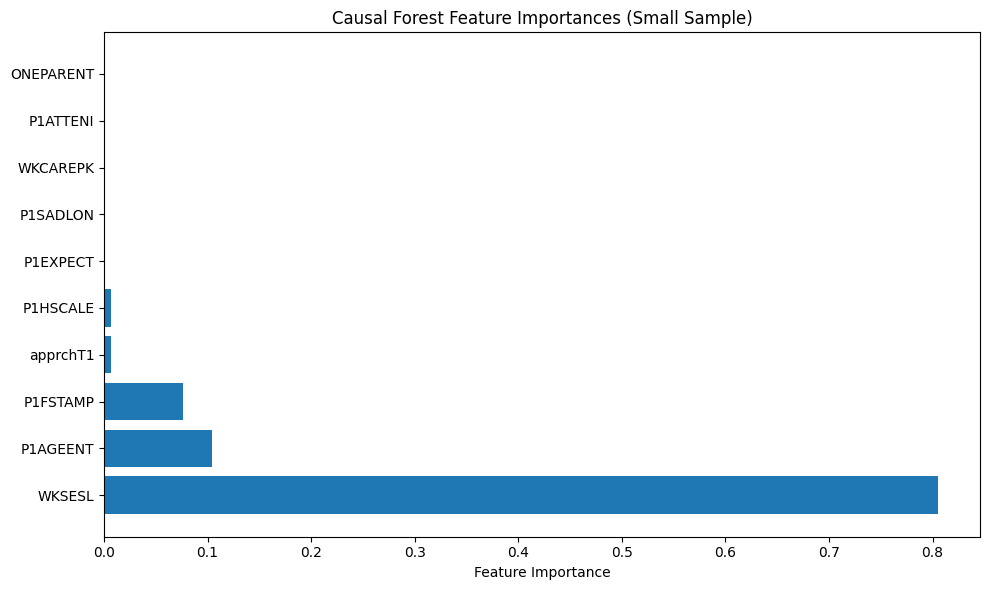

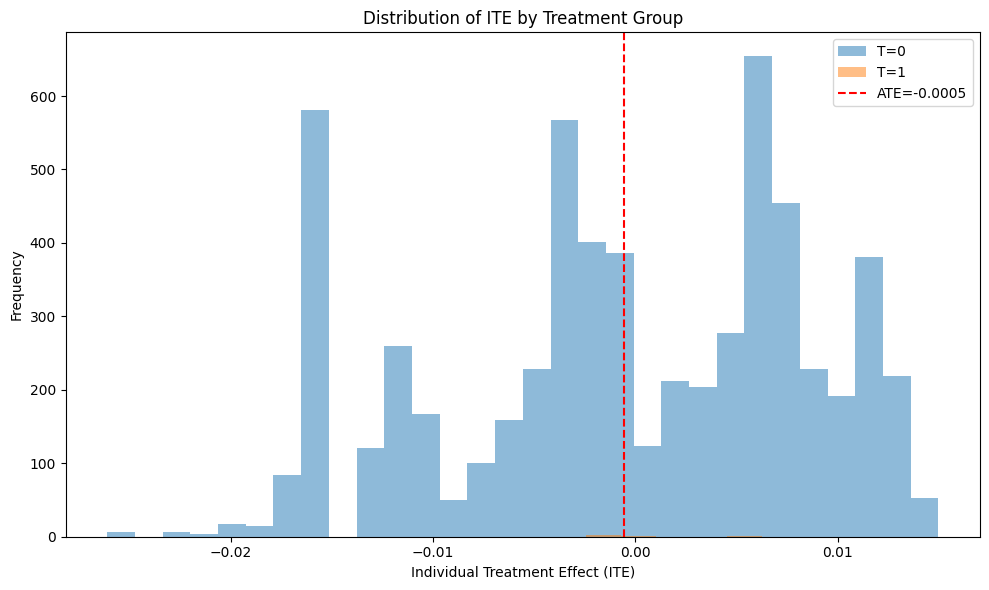


处理组样本的ITE详情：
       CHILDID    ITE_CF SES_group
630   0098017C -0.001759    Medium
821   0147006C -0.002414       Low
5476  1018018C  0.006244    Medium
6247  1212023C -0.002445      High
7240  3080023C  0.000899       Low


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from econml.grf import CausalForest
import matplotlib.pyplot as plt

df = pd.read_csv("final.csv")
y = df["avg_MIRT"].values
T = df["P1EARLY"].values
X = df.drop(columns=["CHILDID", "avg_MIRT", "P1EARLY"])
child_ids = df["CHILDID"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"总样本数：{len(T)}")
print(f"T=0 样本数：{sum(T==0)}")
print(f"T=1 样本数：{sum(T==1)}")

model = CausalForest(
    n_estimators=500,        
    min_samples_leaf=50,   
    min_samples_split=100,  
    max_depth=5,   
    min_weight_fraction_leaf=0.1,
    random_state=42, 
    honest=False 
)

model.fit(X=X_scaled, y=y, T=T)

ite = model.predict(X_scaled)

ate = np.mean(ite)
print(f"\nCausal Forest 估计的 ATE：{ate:.4f}")

df["ITE_CF"] = ite

df["SES"] = df["WKSESL"]
df["SES_group"] = pd.qcut(df["SES"], q=3, labels=["Low", "Medium", "High"])
cate_grouped = df.groupby("SES_group")["ITE_CF"].mean()
print("\n按 SES 分组的 CATE（Causal Forest）：")
print(cate_grouped)

print("\n特征重要性：")
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

for i in sorted_idx:
    print(f"{X.columns[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X.columns[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Causal Forest Feature Importances (Small Sample)")
plt.tight_layout()
plt.savefig("causal_forest_feature_importance_small_sample.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ite[T==0], bins=30, alpha=0.5, label='T=0')
if sum(T==1) > 0:
    plt.hist(ite[T==1], bins=min(5, sum(T==1)), alpha=0.5, label='T=1') 
plt.axvline(x=ate, color='r', linestyle='--', label=f'ATE={ate:.4f}')
plt.xlabel("Individual Treatment Effect (ITE)")
plt.ylabel("Frequency")
plt.title("Distribution of ITE by Treatment Group")
plt.legend()
plt.tight_layout()
plt.savefig("ite_distribution_by_treatment.png")
plt.show()

df.to_csv("causal_forest_results_small_sample.csv", index=False)

print("\n处理组样本的ITE详情：")
treated_samples = df[T == 1]
print(treated_samples[["CHILDID", "ITE_CF", "SES_group"]])

In [ ]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("psm_matched_results.csv")

y = df["Y"]
X = df[["T", "GENDER", "WKWHITE", "WKSESL", "S2KPUPRI", 
        "apprchT1", "P1FSTAMP", "ONEPARENT", "WKCAREPK", 
        "P1HSCALE", "P1SADLON"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC3')

ate = model.params["T"]
conf_int = model.conf_int().loc["T"]
p_value = model.pvalues["T"]

print(f"PSM ATE: {ate:.4f}")
print(f"95% CI: [{conf_int[0]:.4f}, {conf_int[1]:.4f}]")
print(f"P-value: {p_value:.4f}")

PSM ATE: -1.2606
95% CI: [-1.6690, -0.8522]
P-value: 0.0000


In [2]:
import pandas as pd

df = pd.read_csv("psm_matched_results.csv")
print(df.columns.tolist())

['GENDER', 'WKWHITE', 'WKSESL', 'S2KPUPRI', 'apprchT1', 'P1FSTAMP', 'ONEPARENT', 'WKCAREPK', 'P1HSCALE', 'P1SADLON', 'T', 'Y']


In [ ]:
import pandas as pd
import numpy as np

df_bart = pd.read_csv("bart_ite_individuals.csv")

ite_bart = df_bart["ITE"]
ate_bart = ite_bart.mean()
lower, upper = np.percentile(ite_bart, [2.5, 97.5])

print(f"BART ATE: {ate_bart:.4f}")
print(f"95% Credible Interval: [{lower:.4f}, {upper:.4f}]")

BART ATE: -1.5421
95% Credible Interval: [-3.6752, 0.1863]


In [ ]:
import pandas as pd
import numpy as np

df_cf = pd.read_csv("causal_forest_results_small_sample.csv")
ite_cf = df_cf["ITE_CF"].values

ate_cf = np.mean(ite_cf)

np.random.seed(42)
boot_ates = []
for _ in range(1000):
    sample = np.random.choice(ite_cf, size=len(ite_cf), replace=True)
    boot_ates.append(np.mean(sample))

ci_lower, ci_upper = np.percentile(boot_ates, [2.5, 97.5])

print(f"Causal Forest ATE: {ate_cf:.4f}")
print(f"95% Bootstrap CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

Causal Forest ATE: -2.4340
95% Bootstrap CI: [-2.4505, -2.4188]
